In [47]:
import pickle
import rebound
import numpy as np
import pandas as pd
import run_Nbody_inc as Nbod
import generatefeatures as gen
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [49]:
model_features = ['avg_iH1', 'avg_iH2', 'norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1',
                  'norm_max_window10_a1','norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2',
                  'norm_max_window10_a2','norm_std_a3','norm_max_a3', 'norm_std_window10_a3',
                  'norm_max_window10_a3', 'avg_ecross1', 'std_ecross1','max_ecross1', 'min_ecross1',
                  'avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2','avg_ecross3',
                  'std_ecross3', 'max_ecross3', 'min_ecross3', 'norm_a1_slope', 'norm_a2_slope',
                  'norm_a3_slope', 'avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23',
                  'std_beta23','min_beta23','max_beta23']

In [100]:
system = 'Kepler-431'
ext = '_inc'   #'_inc' or ''
shadow = 0

In [101]:
data = pd.read_csv("systems/%s_data.csv"%system, index_col=0)
Nbodydata = pd.read_csv("systems/%s_Nbodyresults%s.csv"%(system, ext),
                        names=["name","id","shadow","maxorbs","P1","sim_time","Eerr",
                               "CPU.time","inc1","inc2","inc3","Omega1","Omega2","Omega3"])
features = pd.read_csv('systems/%s_features%s.csv'%(system, ext))
model = pickle.load(open("models/final_Naireen2018.pkl", "rb"))

#get e
try:
    data["e1"] = np.sqrt(data["h1"]**2 + data["k1"]**2)
    data["e2"] = np.sqrt(data["h2"]**2 + data["k2"]**2)
    data["e3"] = np.sqrt(data["h3"]**2 + data["k3"]**2)
except:
    print "can't find h and k entries, calculating."
    data["h1"], data["k1"] = data["e1"]*np.sin(data["w1"]), data["e1"]*np.cos(data["w1"])
    data["h2"], data["k2"] = data["e2"]*np.sin(data["w2"]), data["e2"]*np.cos(data["w2"])
    data["h3"], data["k3"] = data["e3"]*np.sin(data["w3"]), data["e3"]*np.cos(data["w3"])

can't find h and k entries, calculating.


In [102]:
feat = features[features["shadow"]==shadow]
Nbody = Nbodydata[Nbodydata["shadow"]==shadow]
Nbody = Nbody[Nbody["id"]==feat["id"]]
plotdata = data.iloc[feat["id"]]

In [103]:
feat.iloc[50:55]

,Unnamed: 0,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,...,std_beta12,min_beta12,max_beta12,avg_beta23,std_beta23,min_beta23,max_beta23,name,id,shadow
50,50,0.128053,0.072466,0.000038,0.000102,0.000033,0.000070,0.000081,0.000252,0.000021,...,0.011529,19.425708,19.486619,16.222414,0.009495,16.193798,16.236123,Kepler-431_1.0e+09orbits_id947_shadow0,947,0
51,51,0.093373,0.059714,0.002304,0.005151,0.000121,0.000233,0.002755,0.008039,0.001843,...,0.328150,13.530144,15.159782,16.026254,0.371381,14.975297,16.618792,Kepler-431_1.0e+09orbits_id658_shadow0,658,0
52,52,0.271455,0.053295,0.008602,0.021254,0.000677,0.001181,0.003090,0.008041,0.000208,...,1.839183,18.543271,26.459653,18.823021,0.310670,18.052187,19.373443,Kepler-431_1.0e+09orbits_id749_shadow0,749,0
53,53,0.332037,0.082807,0.042363,0.157745,0.000222,0.000324,0.003384,0.012612,0.000602,...,4.242053,-1.392892,17.146791,14.661104,0.332171,14.221868,15.538957,Kepler-431_1.0e+09orbits_id282_shadow0,282,0
54,54,0.105678,0.079287,0.001053,0.002648,0.001256,0.002331,0.003904,0.013860,0.006346,...,0.550259,17.223281,19.895348,15.343179,0.368653,14.727007,16.681932,Kepler-431_1.0e+09orbits_id919_shadow0,919,0


In [104]:
Nbody.iloc[50:55]

,name,id,shadow,maxorbs,P1,sim_time,Eerr,CPU.time,inc1,inc2,inc3,Omega1,Omega2,Omega3
50,Kepler-431_1.0e+09orbits_id947_shadow0,947,0,1.000000e+09,0.117108,11774.4400,0.000015,2.509603,0.001014,0.000962,0.000804,1.969042,0.161343,3.119440
51,Kepler-431_1.0e+09orbits_id658_shadow0,658,0,1.000000e+09,0.117108,10823.4900,0.000766,2.262116,0.001075,0.000952,0.000876,2.514261,2.908873,5.392618
52,Kepler-431_1.0e+09orbits_id749_shadow0,749,0,1.000000e+09,0.117108,667.6677,0.000592,0.150990,0.001072,0.000985,0.000846,4.352424,2.465665,4.319027
53,Kepler-431_1.0e+09orbits_id282_shadow0,282,0,1.000000e+09,0.117108,573.4700,0.000101,0.134665,0.001099,0.000977,0.000882,5.511254,0.220892,3.694483
54,Kepler-431_1.0e+09orbits_id919_shadow0,919,0,1.000000e+09,0.117108,548.2081,0.000213,0.137798,0.001024,0.000975,0.000835,0.627626,3.037150,4.787414


In [105]:
plotdata.iloc[50:55]

,m1,MA1,P1,e1,w1,m2,MA2,P2,e2,w2,...,P3,e3,w3,Ms,h1,k1,h2,k2,h3,k3
947,0.037746,2.352701,6.803,0.001202,5.878375,0.732843,5.039302,8.703,0.000716,0.069154,...,11.922,0.068449,5.855556,1.071,-0.000473,0.001105,0.000049,0.000714,-0.028387,0.062285
658,0.959655,5.306681,6.803,0.049826,5.559274,0.979768,4.356946,8.703,0.033970,3.925808,...,11.922,0.137372,6.234937,1.071,-0.033001,0.037331,-0.023992,-0.024049,-0.006625,0.137212
749,0.083018,5.444429,6.803,0.000060,2.023584,0.319662,1.607043,8.703,0.127505,0.864837,...,11.922,0.002964,5.411204,1.071,0.000054,-0.000026,0.097030,0.082720,-0.002269,0.001907
282,0.120591,0.703544,6.803,0.002929,6.050565,1.337344,5.683925,8.703,0.037147,2.726106,...,11.922,0.114761,3.235319,1.071,-0.000675,0.002850,0.014994,-0.033986,-0.010740,-0.114257
919,0.763883,3.227834,6.803,0.002688,3.471444,0.347314,0.647812,8.703,0.129077,2.852106,...,11.922,0.024598,3.916564,1.071,-0.000871,-0.002544,0.036846,-0.123706,-0.017211,-0.017574


In [106]:
# get preds
X = xgb.DMatrix(feat[model_features])
proba = model.predict(X)
pstablemask = (proba > 0.5)
punstablemask = (proba <= 0.5)

# get Nbody
stablemask = (Nbody.shadow == shadow)&(Nbody.sim_time/Nbody.P1 >=9.9e8)
unstablemask = (Nbody.shadow == shadow)&(Nbody.sim_time/Nbody.P1 < 9.9e8)
stablemask.sum(), unstablemask.sum(), pstablemask.sum(), punstablemask.sum()

(715, 285, 798, 202)

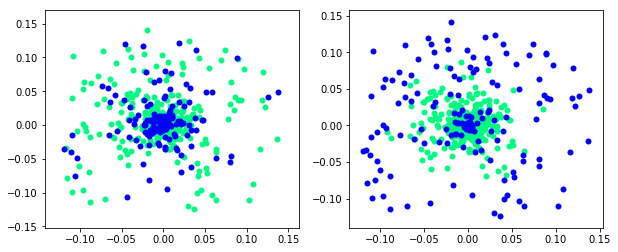

In [108]:
x = "h2"
y = "k2"

colorbar = 'winter'
cmap = matplotlib.cm.get_cmap(colorbar)
f, (ax1, ax2) = plt.subplots(1,2, figsize=[10, 4])
ax1.scatter(plotdata[x][stablemask], plotdata[y][stablemask], c=cmap(0.99), lw=0)
ax1.scatter(plotdata[x][unstablemask], plotdata[y][unstablemask], c=cmap(0.), lw=0)
ax2.scatter(plotdata[x][pstablemask], plotdata[y][pstablemask], c=cmap(0.99), lw=0)
ax2.scatter(plotdata[x][punstablemask], plotdata[y][punstablemask], c=cmap(0.), lw=0)